### Testing Grounds for the active learning step

In [4]:
import sys; sys.path.insert(0, "..") 
import os
import numpy as np
import torch
from src.active_learning.active_learning_loop import ActiveLearningModule
from src.models.models import CustomVGG19
from src.dataset.dataset import Data, CustomSubset, VolumeDataset
from torchvision import transforms, models
from src.dataset.utils import (
    get_balanced_initial_pool,
    train_test_val_split,
)

In [5]:
from torch.hub import load_state_dict_from_url
from torchvision import models

from src.features.convert_images_to_npy import process_cncb_data

def vgg16(num_classes):
        model = models.vgg16(pretrained=False, num_classes=num_classes)
        weights = load_state_dict_from_url(
            "https://download.pytorch.org/models/vgg16-397923af.pth"
        )
        weights = {k: v for k, v in weights.items() if "classifier.6" not in k}
        model.load_state_dict(weights, strict=False)
        return model

model = vgg16(num_classes=3)
# model = patch_module(model)
root_dir = "../data/"
files, classes = process_cncb_data(root_dir=root_dir)
# dataset = Data(data_path="data/NPY/volumes/", target_path="data/NPY/labels/")
dataset = VolumeDataset(files=files, lbls=classes)

c:\Users\Bastian\Desktop\Deep-Bayesian-Active-Learning-for-Covid-19\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bastian\Desktop\Deep-Bayesian-Active-Learning-for-Covid-19\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
# model = CustomVGG19(active_learning_mode=True).cuda()
# model = MobileNetV2()
# dataset = Data(data_path="../data/NPY/volumes/", target_path="../data/NPY/labels/")

load_state = {
    "datasets": "../checkpoints/VGG16_bald_200_0.0001_22_04_2023_12-7/datasets.pickle",
    "model": "../checkpoints/VGG16_bald_200_0.0001_22_04_2023_12-7/model_6_bald_checkpoint.pth",
    "uncertainty": "../checkpoints/VGG16_bald_200_0.0001_22_04_2023_12-7/uncertainty/uncertainty_pool=1000_labelled=84.pkl"
}
model.load_state_dict(torch.load(load_state["model"])["model"])
# load_state["model"] = "../checkpoints/VGG_bald_100_0.0001_05_04_2023_6-28/model_10_bald_checkpoint.pth"

TypeError: __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given

In [4]:
# modify our model to get features
import torch
from torch import nn
from torch.utils.data import DataLoader


# Make a feature extractor from our trained model.
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.extractor = model.features

    def forward(self, x):
        return torch.flatten(self.extractor(x), 1)


In [5]:
import sys; sys.path.insert(0, "..")
import torch
import pickle

# dataset = Data(data_path="../data/NPY/volumes/", target_path="../data/NPY/labels/")
with open(load_state["datasets"], "rb") as handle:
    datasets = pickle.load(handle)
    X_train = ["../" + path for path in datasets["X_train"]]
    y_train = datasets["y_train"]
    X_test = datasets["X_test"]
    y_test = datasets["y_test"]
    X_val = datasets["X_val"]
    y_val = datasets["y_val"]
    print(datasets["inital_pool"])
    initial_pool = datasets["inital_pool"]
train = VolumeDataset(
            files=X_train, lbls=y_train, train_transform=None
        )

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 29, 31, 33, 36]


In [6]:
from baal.active import ActiveLearningDataset, get_heuristic

active_set = ActiveLearningDataset(train)
active_set.load_state_dict(torch.load(load_state["model"])["active_set"])

TypeError: __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given

In [7]:
len(active_set._dataset)

79863

In [8]:
from tqdm import tqdm
from sklearn.decomposition import IncrementalPCA

model.cuda()
features = FeatureExtractor(model)
acc = []

for x, y in tqdm(DataLoader(active_set._dataset, batch_size=16)):
    acc.append((features(x.cuda()).detach().cpu().numpy(), y.detach().cpu().numpy()))
    break

xs, ys = zip(*acc)

  0%|          | 0/4992 [00:06<?, ?it/s]


In [10]:
np.concatenate(xs).shape

(16, 131072)

In [ ]:
from sklearn.decomposition import IncrementalPCA
import numpy as np

df = np.load("VGG16_bald_100_0.001_21_04_2023_15-16.npz")
data = df["x"]
n = data.shape[0] # how many rows we have in the dataset
chunk_size = 5000 # how many rows we feed to IPCA at a time, the divisor of n
ipca = IncrementalPCA(n_components=100, batch_size=16)

for i in tqdm(range(0, n//chunk_size)):
    ipca.partial_fit(data[i*chunk_size : (i+1)*chunk_size])

In [2]:
df = np.load("VGG16_bald_100_0.001_21_04_2023_15-16.npz")
# data = df["x"].astype(np.float16)

In [5]:
import umap
import numpy as np

fitter = umap.UMAP(verbose=True, low_memory=True).fit(data)
embedding = fitter.embedding_

c:\Users\Bastian\Desktop\Deep-Bayesian-Active-Learning-for-Covid-19\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP( verbose=True)
Sun Apr 30 13:40:25 2023 Construct fuzzy simplicial set
Sun Apr 30 13:47:13 2023 Finding Nearest Neighbors
Sun Apr 30 13:49:16 2023 Building RP forest with 19 trees


Text(0.5, 1.0, 'UMAP')

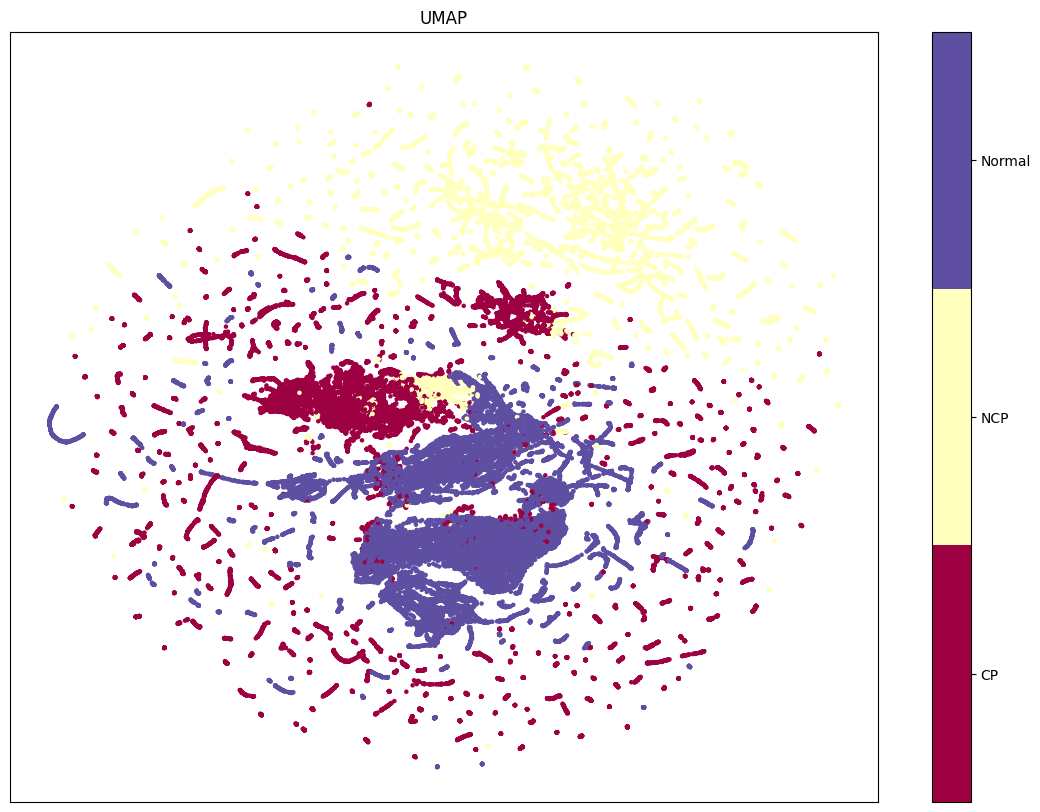

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
# labels = df["y"]
embedding = np.load("embedding_200_VGG16_bald_100_0.001_21_04_2023_15-16.npz")["x"]
classes = ["CP", "NCP", "Normal"]
fig, ax = plt.subplots(1, figsize=(14, 10))
# ax = plt.axes(projection='3d')
plt.scatter(*embedding.T, c=df["y"], s=5, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(0, 4)-.5)
cbar.set_ticks(np.arange(0, 3))
cbar.set_ticklabels(classes)
plt.title("UMAP")

In [ ]:
x_transformed.shape

In [ ]:
from sklearn.manifold import TSNE

# Compute t-SNE on the extracted features.
# df = np.load("VGG16_bald_200_0.0001_24_04_2023_11-9.npz")
tsne = TSNE(n_jobs=4)
transformed = tsne.fit_transform(x_transformed)

In [ ]:
plt.scatter(*transformed.T, s=5, cmap='Spectral', alpha=1.0)
# plt.setp(ax, xticks=[], yticks=[])
# cbar = plt.colorbar(boundaries=np.arange(0, 4)-.5)
# cbar.set_ticks(np.arange(0, 3))
# cbar.set_ticklabels(classes)
plt.title("UMAP")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
labels = data["y"][:7000] #np.concatenate(ys)
def plot(tsne_enc):
# Color and marker for each true class
    colors = cm.rainbow(np.linspace(0, 1, 3))
    markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
    fig, ax = plt.subplots(figsize=(16,10))
    for iclass in range(0, 3):
        # Get indices for each class
        idxs = labels==iclass
        # Scatter those points in tsne dims
        ax.scatter(tsne_enc[idxs, 0],
                   tsne_enc[idxs, 1],
                   marker=markers[iclass],
                   c=colors[iclass],
                   edgecolor=None,
                   label=r'$%i$'%iclass)

    ax.set_title('TSNE', fontsize=24)
    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.tight_layout()

In [ ]:
plot(transformed)

In [ ]:
from baal.utils.plot_utils import make_animation_from_data
import torch
# Create frames to animate the process.
frames = make_animation_from_data(transformed, labels, torch.load(load_state["model"])["labelling_progress"], ["CP", "NCP", "Normal"])


In [ ]:


from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation


def plot_images(img_list):
    def init():
        img.set_data(img_list[0])
        return (img,)

    def animate(i):
        img.set_data(img_list[i])
        return (img,)

    fig = plt.Figure(figsize=(10, 10))
    ax = fig.gca()
    img = ax.imshow(img_list[0])
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(img_list), interval=60, blit=True)
    return anim


HTML(plot_images(frames).to_jshtml())
